## Data preparation and sanitization

In [40]:
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import seaborn as sb

# Read and sanitize the data
df = pd.read_excel("../data/UG_HH_NEW_continuous_no200.xls")
#df = pd.read_excel("./UG_HH_NEW_categorical_no200.xls")

df = df.dropna()


NORMALISE_DATA = False


x = df.values[:, :-1]
y = df.values[:, -1:]

if NORMALISE_DATA:
    x_min = x.min(axis=0)
    x_max = x.max(axis=0)
    x = (x - x_min) / (x_max - x_min)
    
NB_FEATURES = x.shape[1]

## Linear regression (continuous dataset)

**Accuracy / Loss - For model comparison**

In [41]:
MAX_GAIN = 200

def loss(min_offer, predicted):
    """
    Compute loss for the ultimatum game,
    as the difference between the possible gain and the actual one
    """
    min_offer = min_offer.ravel()
    predicted = predicted.ravel()
    rejected = min_offer > predicted
    res = predicted - min_offer
    if rejected.sum() != 0:
        res[rejected] = MAX_GAIN - min_offer[rejected]
    bad_predictions = (predicted < 0) | (predicted > MAX_GAIN)
    if bad_predictions.sum() != 0:
        res[bad_predictions] = MAX_GAIN - min_offer[bad_predictions]
    return res

def loss_sum(min_offer, predicted):
    return loss(min_offer, predicted).sum()

def avg_loss(min_offer, predicted):
    """
    Compute avg loss for the ultimatum game
    """
    return np.mean(loss(min_offer, predicted))

def mse(min_offer, predicted):
    """
    Compute mse using the loss as error
    """
    return np.mean(np.square(loss(min_offer, predicted)))

def rejection_ratio(min_offer, predicted):
    """
    Compute ratio of rejected proposals without consideration of values
    """
    accepted = (min_offer <= predicted)
    return 1 - np.mean(accepted)

def avg_win_loss(min_offer, predicted):
    """
    Compute avg_loss of accepted proposals
    """
    min_offer = min_offer.ravel()
    predicted = predicted.ravel()
    accepted = (min_offer <= predicted)
    if accepted.sum() == 0:
        return 0
    return avg_loss(min_offer[accepted], predicted[accepted])


def gain(min_offer, predicted):
    min_offer = min_offer.ravel()
    predicted = predicted.ravel()    
    res = MAX_GAIN - predicted
    res[predicted < min_offer] = 0
    return res

def avg_loss_ratio(min_offer, predicted):
    """
    Compute the avg gain ratio in relation to the maximal gain
    """
    return 1 - np.mean(gain(min_offer, predicted) / gain(min_offer, min_offer))


#### Benchmark

In [42]:
benchmark_functions = [avg_loss, mse, rejection_ratio, avg_win_loss, avg_loss_ratio, loss_sum]

from sklearn.model_selection import KFold
import numpy as np

def process_model(model, xTrain, yTrain, xTest, yTest, fit_kwargs=None, predict_kwargs=None):
    fit_kwargs = {} if fit_kwargs is None else fit_kwargs
    predict_kwargs = {} if predict_kwargs is None else predict_kwargs
    model.fit(xTrain, yTrain, **fit_kwargs)
    yPredict = model.predict(xTest, **predict_kwargs)
    results = {func.__name__: func(yTest, yPredict) for func in benchmark_functions}
    return results
    
def process_benchmark_cv(model, X, y, cv=5, metrics=None, fit_kwargs=None, predict_kwargs=None):
    # We make sure original values aren't modified, even by mistake
    X = np.copy(X)
    y = np.copy(y)
    
    kf = KFold(n_splits=cv)
    results = []
    for train_index, test_index in kf.split(X):
        xTrain, yTrain = X[train_index], y[train_index]
        xTrain, yTrain = DACombine().fit_predict(xTrain, yTrain)
        xTest, yTest = X[test_index], y[test_index]
        benchmark_result = process_model(model, xTrain, yTrain, xTest, yTest, fit_kwargs, predict_kwargs)
        results.append(benchmark_result)
    return pd.DataFrame(results)

In [43]:
#keras
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import multiply
from keras.wrappers.scikit_learn import KerasRegressor
import keras.backend as K
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import tensorflow as tf
import sys


def sigmoid1024_tf(x):
    return (1024**x) / (1024**x + 1)

def sigmoid_tf(x):
    return K.sigmoid(x)

def gain_tf(x):
    math_pi = tf.constant(math.pi)
    one = tf.constant(1.0)
    ten = tf.constant(10.0)
    x = tf.math.subtract(y_true, y_pred)
    x = tf.math.truediv(x, ten)
    left_mul = sigmoid_tf(x)
    right_mul = tf.math.cos(tf.math.divide(x, math_pi))
    return tf.math.multiply(left_mul, right_mul)

def loss_tf(y_true, y_pred):
    math_pi = tf.constant(math.pi)
    one = tf.constant(1.0)
    ten = tf.constant(10.0)
    x0 = tf.math.subtract(y_true, y_pred)
    x = tf.math.truediv(x0, ten)
    left_mul = sigmoid_tf(x)
    right_mul = tf.math.cos(tf.math.divide(x, math_pi))
    return tf.math.subtract(one*2, tf.math.multiply(left_mul, right_mul))

def _keras_model(loss=None, metrics=None):
    """
    build a simple regression model
    :param loss: (str|callable, default: loss_tf)
    """
    if loss is None:
        loss = loss_tf
    if metrics is None:
        metrics = ["mae"]
    model = Sequential()
    model.add(Dense(1, input_dim=NB_FEATURES, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    model.compile(loss=loss, optimizer='adam', metrics=metrics)
    return model

def keras_model(loss=None, metrics=None, nb_epoch=100, batch_size=32, verbose=False):
    build_fn = lambda : _keras_model(loss, metrics)
    return KerasRegressor(build_fn=build_fn, epochs=nb_epoch, batch_size=batch_size, verbose=verbose)

In [44]:
# #sci-kit like training
# sm = keras_model("mse") 
# history = sm.fit(xTrain, yTrain, validation_split=0.33, epochs=100, batch_size=64, verbose=0)
# loss_hist = pd.DataFrame(data={'loss': history.history['loss']})
# loss_hist.plot(figsize=(30,10))
# smPredict = sm.predict(xTest, batch_size=128)

# out_data = pd.DataFrame(data={'y_test': np.ravel(yTest), 'y_pred': np.ravel(smPredict)})
# stl = sm.evaluate(xTest, yTest, verbose=0)
# print("Results: %2.2f (%.2f) MSE, Scalar test loss: %.2f" % (smPredict.mean(), smPredict.std(), stl))
# #out_data.plot(figsize=(30,10))

**Featureless model (fixed value)**

In [45]:
class FeatureLessModel(object):
    def __init__(self, max_value, loss=None):
        self.value = None
        self.max_value = max_value
        self.loss = loss or avg_loss_ratio
        self._trained = False
    
    def fit(self, xTrain, yTrain, **kwargs):
        min_loss = float('inf')
        best_value = 0
        for value in np.arange(self.max_value):
            fixedPredict = np.ones_like(yTrain) * value
            loss = self.loss(yTrain, fixedPredict)
            if loss < min_loss:
                min_loss = loss
                best_value = value
        self._trained = True
        self.value = best_value
    
    def predict(self, xTrain, **kwargs):
        if not self._trained:
            raise ValueError("The model first need to be trained!!!")
        res = np.ones((xTrain.shape[0], 1) ) * self.value
        return res

    


**Convervative model**

In [46]:
class ConservativeModel(object):
    def __init__(self, max_value):
        self.value = None
        self.max_value = max_value
        self._trained = False

    def fit(self, xTrain, yTrain, **kwargs):
        self.value = self.max_value - 1
        self._trained = True
    
    def predict(self, xTest, **kwargs):
        if not self._trained:
            raise ValueError("The model should first be trained")
        return np.ones((xTest.shape[0], 1)) * self.value

**Linear regression**

In [47]:
from sklearn.linear_model import LinearRegression

**Random**

In [48]:
class RandomModel(object):
    def __init__(self, max_value):
        self.value = max_value
        self._trained = False

    def fit(self, xTrain, yTrain, **kwargs):
        self._trained = True
    
    def predict(self, xTest, **kwargs):
        if not self._trained:
            raise ValueError("The model should first be trained")
        return np.random.random((xTest.shape[0], 1)) * self.value

**Random Forest**

In [49]:
from sklearn.ensemble.forest import RandomForestClassifier, RandomForestRegressor

**Clustering**

In [50]:
from sklearn.cluster import KMeans, MeanShift, DBSCAN, SpectralClustering, Birch, MiniBatchKMeans, AffinityPropagation
from sklearn.mixture import BayesianGaussianMixture


class ClusterModel(object):
    def __init__(self, **kwargs):
        if "base_model" in kwargs:
            base_model_ = kwargs.pop("base_model")
            if isinstance(base_model_, str):
                models = {
                    "kmeans": KMeans,
                    "meanshift": MeanShift,
                    "birch": Birch,
                    "spectral": SpectralClustering,
                    "minibatch": MiniBatchKMeans,
                    "affinity": AffinityPropagation,
                    "bayes": BayesianGaussianMixture,
                }
                self.base_model = models.get(base_model_, MeanShift)(**kwargs)
            else:
                self.base_model = base_model_
        else:
            self.base_model = MeanShift(**kwargs)
        super().__init__()
        self.clustersClasses = None
        self._trained = False
    
    def fit(self, xTrain, yTrain, **kwargs):
        self.base_model.fit(xTrain)
        labels = np.array([item for item in np.unique(self.base_model.labels_) if item >= 0])
        clustersClasses = np.zeros_like(labels)
        for cluster in range(len(labels)):
            values = yTrain[self.base_model.labels_==cluster]
            clustersClasses[cluster] = values.mean() + values.std()
        self.clustersClasses = clustersClasses
        self._trained = True
    
    def predict(self, xTest, **kwargs):
        if self._trained is None:
            raise ValueError("Model not trained yet")
        predClusters = self.base_model.predict(xTest)
        return self.clustersClasses[predClusters]

class ClusterExtModel(object):
    def __init__(self, **kwargs):
        if "base_model" in kwargs:
            base_model_ = kwargs.pop("base_model")
            if isinstance(base_model_, str):
                models = {
                    "kmeans": KMeans,
                    "meanshift": MeanShift,
                    "birch": Birch,
                    "spectral": SpectralClustering,
                    "minibatch": MiniBatchKMeans,
                    "affinity": AffinityPropagation,
                    "bayes": BayesianGaussianMixture,
                }
                self.base_model = models.get(base_model_, MeanShift)(**kwargs)
            else:
                self.base_model = base_model_
        else:
            self.base_model = MeanShift(**kwargs)
        self._trained = False
        self.sub_models = None
        self.max_value = MAX_GAIN
        
    def fit(self, xTrain, yTrain, **kwargs):        
        self.base_model.fit(xTrain, yTrain, **kwargs)
        labels = np.array([item for item in np.unique(self.base_model.labels_) if item >= 0])
        clustersClasses = np.zeros_like(labels)
        sub_models = []
        for cluster in range(len(labels)):
            sub_model = FeatureLessModel(self.max_value)
            mask = self.base_model.labels_==cluster
            sub_model.fit(xTrain[mask], yTrain[mask])
            sub_models.append(sub_model)
        # We use an array instead of a list for better indexing
        self.clustersClasses = [sub_model.value for sub_model in sub_models]
        self.sub_models = np.array(sub_models)
        self._trained = True
    
    def predict(self, xTest, **kwargs):
        if self._trained is None:
            raise ValueError("Model not trained yet")
        predClusters = self.base_model.predict(xTest)
        sub_models = self.sub_models[predClusters]
        preds = []
        dummy_x = np.array([0])
        for idx in range(xTest.shape[0]):
            preds.append(sub_models[idx].predict(dummy_x))
        res = np.array(preds).ravel()
        return res
        #return self.clustersClasses[predClusters]
            

** Data augmentation **

In [51]:
class DACombine(object):
    def __init__(self, size=None, nb_features=NB_FEATURES):
        self.size = size
        self.nb_features = nb_features
    
    def fit_predict(self, xTrain, yTrain, size=None):
        size = size or self.size or len(xTrain) * 4
        indices = np.arange(self.nb_features)
        np.random.shuffle(indices)
        targets = yTrain.ravel()
        xRes = []
        yRes = []
        for _ in range(size):
            target = np.random.choice(targets)
            target_mask = yTrain.ravel()==target
            xTrain_target = xTrain[target_mask]
            i = np.random.randint(xTrain_target.shape[0])
            j = np.random.randint(xTrain_target.shape[0])
            x = np.zeros_like(xTrain_target[0])
            np.random.shuffle(indices)
            split = int(np.random.randint(self.nb_features))
            mask_i = indices[:split]
            mask_j = indices[split:]
            x[mask_i] = xTrain_target[i, mask_i]
            x[mask_j] = xTrain_target[j, mask_j]
            xRes.append(x)
            yRes.append(target)
        return np.array(xRes), np.array(yRes)
        
        

**Baseline models**

In [52]:
benchmark_models = {
    #Featureless:
    "random": RandomModel(MAX_GAIN),
    "conservative": ConservativeModel(MAX_GAIN),
    "featureless": FeatureLessModel(MAX_GAIN),
    #"linear_regressor": LinearRegression(copy_X=False),
}

results = {key: process_benchmark_cv(model, x, y.ravel()) for key, model in benchmark_models.items()}

results_mean = {key: item.mean() for key, item in results.items()}
results_std = {key: item.std() for key, item in results.items()}
pd.DataFrame(results_mean).T

,avg_loss,avg_loss_ratio,avg_win_loss,loss_sum,mse,rejection_ratio
conservative,119.215079,0.990177,119.215079,4267.200000,15084.700794,0.000000
featureless,26.897619,0.218127,24.028855,963.000000,1510.321429,0.066825
random,80.169453,0.686153,64.867733,2868.724604,8065.651091,0.358787


In [53]:
# df_results_mean = pd.DataFrame(results_mean)
# df_results_std = pd.DataFrame(results_std)
# df_results_mean.plot.bar(logy=True, figsize=(15, 5))

**Clustering based models**

In [54]:
# benchmark_models = {
#     #Cluster-based
#     "affinity": ClusterModel(base_model="affinity"),
#     "bayes": ClusterModel(base_model="bayes", n_components=8),
#     "birch": ClusterModel(base_model="birch"),
#     "kmeans": ClusterModel(base_model="kmeans", n_clusters=16),
#     "meanshift": ClusterModel(base_model="meanshift", cluster_all=True),
#     "affinity_ext": ClusterExtModel(base_model="affinity"),
#     "bayes_ext": ClusterExtModel(base_model="bayes", n_components=8),
#     "birch_ext": ClusterExtModel(base_model="birch"),
#     "kmeans_ext": ClusterModel(base_model="kmeans", n_clusters=16),
#     "meanshift_ext": ClusterExtModel(base_model="meanshift", cluster_all=True),
# }

# results = {key: process_benchmark_cv(model, x, y.ravel()) for key, model in benchmark_models.items()}

# results_mean = {key: item.mean() for key, item in results.items()}
# results_std = {key: item.std() for key, item in results.items()}
# pd.DataFrame(results_mean).T

In [55]:
# df_results_mean = pd.DataFrame(results_mean)
# df_results_std = pd.DataFrame(results_std)
# df_results_mean.plot.bar(logy=True, figsize=(15, 5))

**Other models**

In [56]:
benchmark_models = {
    # Regression
    "random_forest_regr": RandomForestRegressor(min_samples_leaf=5),
    "nn_regression:": keras_model(),
    
    # Classification
    "random_forest": RandomForestClassifier(min_samples_leaf=5),#max_depth=3, random_state=0, n_estimators=10),
}

results = {key: process_benchmark_cv(model, x, y.ravel()) for key, model in benchmark_models.items()}

results_mean = {key: item.mean() for key, item in results.items()}
results_std = {key: item.std() for key, item in results.items()}
pd.DataFrame(results_mean).T

,avg_loss,avg_loss_ratio,avg_win_loss,loss_sum,mse,rejection_ratio
nn_regression:,98.363827,0.857665,9.482579,3525.658008,11581.679462,0.842540
random_forest,36.180952,0.315999,12.455026,1295.000000,3496.095238,0.251270
random_forest_regr,70.401708,0.646872,16.841368,2521.450982,7228.438942,0.602857


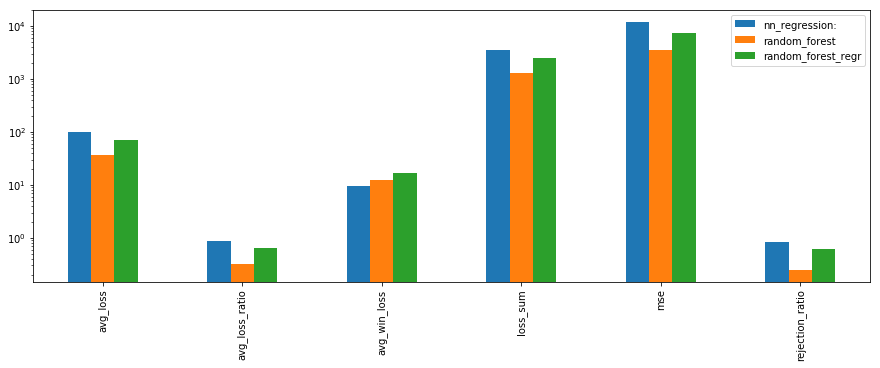

In [57]:
df_results_mean = pd.DataFrame(results_mean)
df_results_std = pd.DataFrame(results_std)
df_results_mean.plot.bar(logy=True, figsize=(15, 5))